In [148]:
#Set environment variables for our notebook
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'bigqueryliquor.json'
#Imports google cloud client library and initiates BQ service
from google.cloud import bigquery
bigquery_client = bigquery.Client()
#Write Query on BQ (in this case we retrieve data within the 2018-01-01 to 2018-12-31 timeframe and focus on the Hy-Vee 
#store, as we found in our initial data analysis that Hy-Vee sold the most liquors over the years in Iowa)
QUERY = """
SELECT
  *
FROM 
  `liquor-store-sale-capstone.liquor_store_sales.Iowa_Hy-Vee_Liquor_Sale_Beg2012_NoNull`
ORDER BY RAND()
LIMIT 10000
  """
#Run the query and write result to a pandas data frame
Query_Results = bigquery_client.query(QUERY)
df = Query_Results.to_dataframe()

In [149]:
import pandas as pd
pd.set_option('display.max_columns',None)

In [150]:
#In order for easy data processing, all the preprocessing processes done in the 'EDA, Location Analysis, Time Series.ipynb'
#have been streamlined into 'dataprocessing.py'
# %load_ext autoreload
# %autoreload 2
from dataprocessing import preprocessing

In [151]:
#streamlined preprocessing data
import warnings
warnings.filterwarnings('ignore')
df = preprocessing(df)

In [152]:
df.head()

,date,store_number,address,city,zip_code,county,vendor_number,vendor_name,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit_per_bottle,profit_per_sale,coordinates,liquor_type,month,year,day_of_year,day_of_week,store_type
0,2020-03-02,2647,5050 Edgewood Rd,Cedar Rapids,52411.0,LINN,370,PERNOD RICARD USA,Absolut Grapefruit,12,750,9.99,14.99,3,44.97,2.25,5.00,15.00,"[42.030129, -91.701581]",vodka,3,2020,62,0,Supermarket
1,2012-10-30,2656,300 10TH ST,CORNING,51632,Clayton,35,"Bacardi U.S.A., Inc.",Bacardi Gold Rum,12,750,7.53,11.30,2,22.60,1.50,3.77,7.54,"[40.991861, -94.731809]",rum,10,2012,304,1,Supermarket
2,2021-07-30,2621,3301 Gordon Dr,Sioux City,51105.0,WOODBURY,395,PROXIMO,1800 Ultimate Raspberry Margarita,6,1750,10.04,15.06,4,60.24,7.00,5.02,20.08,"[42.487752, -96.364108]",other,7,2021,211,4,Supermarket
3,2013-12-23,2635,4064 E 53RD ST,DAVENPORT,52807,Scott,395,Proximo,Jose Cuervo Especial Reposado Tequila,6,1750,20.25,30.37,6,182.22,10.50,10.12,60.72,"[41.574973, -90.513769]",tequila,12,2013,357,0,Supermarket
4,2019-07-25,2627,3330 Martin Luther King Jr Pkwy,Des Moines,50310.0,POLK,434,LUXCO INC,Lady Bligh Spiced Rum,12,1000,7.25,10.88,4,43.52,4.00,3.63,14.52,"[41.625924, -93.65078800000002]",rum,7,2019,206,3,Liquor Store


In [153]:
#As we can see, the dataset includes both categorical and numerical data that might be helpful for our unsupervised 
#learning, therefore we will use K-Prototypes as our clustering algorhithm because the traditional K-Means is calculated
#using Euclidian distance that is only suitable for numerical data, although we could try encoding our categorical 
#variables. Since our data set doesn't contain so many features and we will like drop some of them, we will just focus on
#K-prototypes
import copy
ul=copy.deepcopy(df)

In [154]:
from kmodes.kprototypes import KPrototypes

In [155]:
#First we lower case the whole dataset to avoid duplicates in string type
ul = ul.applymap(lambda s: s.lower() if type(s) == str else s)

In [156]:
#And now we inspect the data types of each column to make sure they are correct
ul.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9988 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 9988 non-null   datetime64[ns]
 1   store_number         9988 non-null   object        
 2   address              9988 non-null   object        
 3   city                 9988 non-null   object        
 4   zip_code             9988 non-null   object        
 5   county               9975 non-null   object        
 6   vendor_number        9988 non-null   object        
 7   vendor_name          9988 non-null   object        
 8   item_description     9988 non-null   object        
 9   pack                 9988 non-null   int64         
 10  bottle_volume_ml     9988 non-null   int64         
 11  state_bottle_cost    9988 non-null   float64       
 12  state_bottle_retail  9988 non-null   float64       
 13  bottles_sold         9988 non-nul

In [157]:
#From the summary above, we found the following columns need to be converted to int type:
type_change=['store_number','zip_code','vendor_number']

In [158]:
ul[type_change]=ul[type_change].apply(pd.to_numeric).astype(int)

In [159]:
ul.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9988 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 9988 non-null   datetime64[ns]
 1   store_number         9988 non-null   int32         
 2   address              9988 non-null   object        
 3   city                 9988 non-null   object        
 4   zip_code             9988 non-null   int32         
 5   county               9975 non-null   object        
 6   vendor_number        9988 non-null   int32         
 7   vendor_name          9988 non-null   object        
 8   item_description     9988 non-null   object        
 9   pack                 9988 non-null   int64         
 10  bottle_volume_ml     9988 non-null   int64         
 11  state_bottle_cost    9988 non-null   float64       
 12  state_bottle_retail  9988 non-null   float64       
 13  bottles_sold         9988 non-nul

In [160]:
#Now we downcast data types to make our memory usage even smaller(For practice purpose because the memory usage is very
#small)
for column in ul:
    if ul[column].dtype == "float64":
        ul[column] = pd.to_numeric(ul[column], downcast="float")
    if ul[column].dtype == "int64":
        ul[column] = pd.to_numeric(ul[column], downcast="unsigned")

In [161]:
#Some columns are good for converting to category types
type_change=['item_description','liquor_type','store_type']
ul[type_change]=ul[type_change].astype('category')

In [162]:
ul.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9988 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 9988 non-null   datetime64[ns]
 1   store_number         9988 non-null   int32         
 2   address              9988 non-null   object        
 3   city                 9988 non-null   object        
 4   zip_code             9988 non-null   int32         
 5   county               9975 non-null   object        
 6   vendor_number        9988 non-null   int32         
 7   vendor_name          9988 non-null   object        
 8   item_description     9988 non-null   category      
 9   pack                 9988 non-null   uint8         
 10  bottle_volume_ml     9988 non-null   uint16        
 11  state_bottle_cost    9988 non-null   float32       
 12  state_bottle_retail  9988 non-null   float32       
 13  bottles_sold         9988 non-nul

In [163]:
#Now we take a look at categorical data value counts
#df.select_dtypes('object').value_counts()
for column in ul:
    if ul[column].dtype == "object":
        print(column,ul[column].nunique())

address 168
city 87
county 71
vendor_name 145


TypeError: unhashable type: 'list'

In [164]:
#Since column 'coordinates' are a list, we use the following method to count unique values:
def nunique_list(list):
    import numpy as np
    return(len(np.unique(np.array(list))))

In [165]:
nunique_list(ul['coordinates'])

229

In [166]:
#Because these object columns have too many unique values, and they are dubplicates with other columns, for example, vendor
#name could also be represented by vendor number, address, city, county, and coordinates can be representaed by
#zip code and store number (and we will do separate location analysis) we will drop them

In [167]:
ul.select_dtypes('category').nunique()

item_description    1903
liquor_type            9
store_type             5
dtype: int64

In [168]:
#we will drop item_description column for sure.

In [169]:
ul.describe()  

,store_number,zip_code,vendor_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit_per_bottle,profit_per_sale,month,year,day_of_year,day_of_week
count,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000
mean,2596.559271,51348.656187,266.808771,11.520124,917.355827,10.541506,15.825230,10.312775,148.215469,9.504123,5.283767,49.487629,6.626652,2016.670404,186.397677,1.684421
std,113.157592,1008.072176,143.227125,6.898388,485.460359,7.956723,11.932923,25.627987,440.974976,28.328539,3.978327,146.759949,3.467233,2.893576,105.985748,1.332456
min,2501.000000,50009.000000,35.000000,1.000000,50.000000,0.000000,0.000000,1.000000,0.000000,0.050000,-2.990000,-8.970000,1.000000,2012.000000,2.000000,0.000000
25%,2556.000000,50320.000000,115.000000,6.000000,750.000000,6.210000,9.395000,3.000000,37.139999,1.880000,3.150000,12.360000,4.000000,2014.000000,95.750000,1.000000
50%,2597.000000,51201.000000,260.000000,12.000000,750.000000,8.500000,12.740000,6.000000,78.480003,6.000000,4.250000,26.160000,7.000000,2017.000000,184.000000,2.000000
75%,2633.000000,52403.000000,389.000000,12.000000,1000.000000,12.800000,19.202500,12.000000,148.440002,10.500000,6.457500,49.500000,10.000000,2019.000000,278.000000,3.000000
max,6243.000000,57222.000000,978.000000,48.000000,3000.000000,175.270004,262.910004,672.000000,17820.000000,1050.000000,87.639999,5940.000000,12.000000,2022.000000,366.000000,6.000000


In [170]:
#And we check to make sure data doesnt contain missing values
ul.isna().sum() 

date                    0
store_number            0
address                 0
city                    0
zip_code                0
county                 13
vendor_number           0
vendor_name             0
item_description        0
pack                    0
bottle_volume_ml        0
state_bottle_cost       0
state_bottle_retail     0
bottles_sold            0
sale_dollars            0
volume_sold_liters      0
profit_per_bottle       0
profit_per_sale         0
coordinates             0
liquor_type             0
month                   0
year                    0
day_of_year             0
day_of_week             0
store_type              0
dtype: int64

In [173]:
#Remove rows for which the county column value is null
# ul=df.dropna(subset=[col])
# ul.isna().sum()

In [174]:
ul.drop(['address','city','county','vendor_name','coordinates','item_description','date','day_of_year','day_of_week',
         'month','year'],axis=1,inplace=True) #We also drop anything related to time because: 1. We do time series analysis
# separately. 2.the clustering algorithm needs the assumption that the rows in the data represent the unique observation 
# observed in a certain time period

In [184]:
catColumnsPos= [ul.columns.get_loc(col) for col in (list(ul.select_dtypes('category').columns)) or 
                (list(ul.select_dtypes('object').columns))]
print('Categorical columns {}'.format(list(ul.select_dtypes('category').columns) or 
                                      listlist(ul.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns ['liquor_type', 'store_type']
Categorical columns position  : [12, 13]


In [185]:
#Convert data frame to the matrix to help kmodes module run the algorithm
ulMatrix=ul.to_numpy()
ulMatrix

array([[2647, 52411, 370, ..., 15.0, 'vodka', 'supermarket'],
       [2656, 51632, 35, ..., 7.539999961853027, 'rum', 'supermarket'],
       [2621, 51105, 395, ..., 20.079999923706055, 'other',
        'supermarket'],
       ...,
       [2593, 51401, 421, ..., 51.959999084472656, 'schnapps',
        'supermarket'],
       [2521, 50265, 260, ..., 19.0, 'vodka', 'drug store'],
       [2548, 50009, 205, ..., 5.25, 'vodka', 'supermarket']],
      dtype=object)

In [186]:
#Using Elbow method to determine the optimal number of clusters for K-Prototype clusters

cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(ulMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


ValueError: All arrays must be of the same length

In [187]:
#Converting the results into a dataframe
ul_cost = pd.DataFrame({'Cluster':range(1, 10), 'Cost':cost})

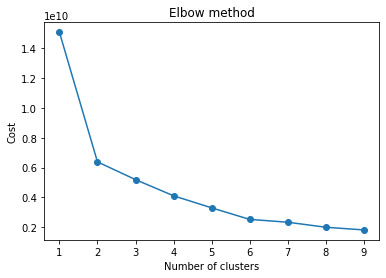

In [192]:
#Visualize the Elbow Plot
import matplotlib.pyplot as plt
plt.plot(range(1,10), cost, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.show()

In [193]:
#From the plot above, we could choose number of cluster k=6

In [194]:
#Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 6, init = 'Huang', random_state = 42)
kprototype.fit_predict(ulMatrix, categorical = catColumnsPos)

array([5, 4, 2, ..., 4, 3, 3], dtype=uint16)

In [195]:
#See the cluster centroid
kprototype.cluster_centroids_

array([['2594.063897763578', '52378.753993610226', '259.43130990415335',
        '5.922257720979766', '1767.9978700745473', '12.133045747511176',
        '18.227177869778473', '9.174653887113951', '161.71385548036065',
        '16.127955273190498', '6.094132039747553', '54.09051125600569',
        'whisky', 'supermarket'],
       ['2606.137931034483', '51205.93103448276', '251.6551724137931',
        '8.793103448275861', '1198.2758620689656', '17.72758622827201',
        '26.59275870487608', '326.8965517241379', '6265.297228582974',
        '385.44827586206895', '8.865172427276086', '2085.101381499192',
        'whisky', 'supermarket'],
       ['2597.9003623188405', '50470.171195652176', '276.6675724637681',
        '5.884057971014493', '1777.8985507246377', '12.34668473057125',
        '18.544456563134123', '8.4375', '151.70019089916477',
        '14.902445653426474', '6.197771723287693', '50.71027171331039',
        'whisky', 'supermarket'],
       ['2600.6527030851967', '50348.20181

In [196]:
#check the iteration of the clusters created
kprototype.n_iter_

8

In [197]:
#check the cost of the clusters created
kprototype.cost_

2521970633.848912

In [204]:
#Add the cluster labels to the dataframe
ul['cluster_label'] = kprototype.labels_
ul['segment'] = ul['cluster_label'].map({0:'first', 1:'second', 2:'third', 3:'fourth', 4:'fifth', 5:'sixth'})

In [205]:
#Order the cluster
ul['segment']=ul['segment'].astype('category')
ul['segment'] = ul['segment'].cat.reorder_categories(['first','second','third','fourth','fifth','sixth'])

In [212]:
#Cluster interpretation
ul.rename(columns = {'cluster_label':'total'}, inplace = True)
ul.groupby('segment').agg(
    {
        'total':'count',
        'store_number':pd.Series.mode,
        'zip_code':pd.Series.mode,
        'vendor_number':pd.Series.mode,
        'pack':pd.Series.mode,
        'bottle_volume_ml':'mean',
        'state_bottle_cost':'mean',
        'state_bottle_retail':'mean',
        'bottles_sold':'mean',
        'sale_dollars':'mean',
        'volume_sold_liters':'mean',
        'profit_per_bottle':'mean',
        'profit_per_sale':'mean',
        'liquor_type':pd.Series.mode,
        'store_type':pd.Series.mode
    }
).reset_index()

,segment,total,store_number,zip_code,vendor_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit_per_bottle,profit_per_sale,liquor_type,store_type
0,first,939,2616,52402,260,6,1767.997870,12.133046,18.227179,9.174654,161.713852,16.127954,6.094132,54.090511,whisky,supermarket
1,second,29,2633,50320,260,"[6, 12]",1198.275862,17.727587,26.592758,326.896552,6265.297363,385.448273,8.865172,2085.101318,whisky,supermarket
2,third,1104,2663,50401,434,6,1777.898551,12.346684,18.544456,8.437500,151.700195,14.902446,6.197772,50.710270,whisky,supermarket
3,fourth,3533,2633,50320,260,12,699.207472,10.130713,15.206941,10.175771,135.067795,7.097048,5.076227,45.068497,whisky,supermarket
4,fifth,1224,2565,51501,260,12,695.955882,10.046560,15.078644,8.016340,104.190750,5.849502,5.032084,34.772099,whisky,supermarket
5,sixth,3159,2512,52402,260,12,690.946502,10.022688,15.042947,9.443178,118.592033,6.305486,5.020259,39.648903,whisky,supermarket
